In [38]:
import torch
import torchvision
import torchvision.transforms as transforms

# Define transforms for data augmentation and normalization
transform = transforms.Compose([transforms.Resize((224, 224)), 
                                transforms.ToTensor(), 
                                transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
                               ])

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
num_labels = 10

device = 'cuda'

# Create DataLoader for batch processing
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1000, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [39]:
import torch.nn as nn
import torchvision.models as models
import numpy as np
from tqdm import tqdm

# Load pretrained ResNet model and modify it to act as a feature extractor
resnet50 = models.resnet50(pretrained=True)
resnet50 = nn.Sequential(*list(resnet50.children())[:-1])  # Remove the final classification layer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50 = resnet50.to(device)

# Function to extract features
def extract_features(dataloader, dataset_name='Dataset'):
    resnet50.eval()  # Set model to evaluation mode
    features = []
    labels = []
    with torch.no_grad():
        for inputs, targets in tqdm(dataloader, desc=f'Extracting features from {dataset_name}', unit='batch', total=len(dataloader)):
            outputs = resnet50(inputs.to(device)).squeeze()
            features.append(outputs.cpu())
            labels.append(targets)
    return torch.vstack(features), torch.hstack(labels)



# Extract features from train and test set
train_features, train_labels = extract_features(trainloader, 'Train Set')
test_features, test_labels = extract_features(testloader, 'Test Set')

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Extracting features from Test Set: 100%|██████████| 10/10 [00:18<00:00,  1.88s/batch]


In [40]:
from sklearn.metrics.pairwise import cosine_similarity

def get_top_k_matches(train_features, test_features, train_indices, k=50):
    if len(train_indices) == 0:
        return np.array([[] for _ in test_features])

    # Get the features of images belonging to the same cluster
    cluster_features = train_features[train_indices]

    # Compute cosine similarity between the test image and cluster images
    similarities = cosine_similarity(test_features, cluster_features)
    
    # Get the top k most similar images
    top_k_indices = np.argsort(similarities, axis=1)[:, ::-1][:, :k]
    return train_indices[top_k_indices]

In [41]:
def precision_at_k(true_label, top_k_labels, k):
    top_k = top_k_labels[:k]
    correct = torch.sum(top_k == true_label).item()
    return correct / k

def mean_average_precision(true_label, top_k_labels):
    # Calculate precision at each rank and then compute average precision
    precisions = []
    correct = 0
    for i, label in enumerate(top_k_labels):
        if label == true_label:
            correct += 1
            precisions.append(correct / (i + 1))
    return np.mean(precisions) if precisions else 0


In [42]:
from collections import defaultdict

def generate_random_hyperplanes(num_features, num_planes):
    return torch.randn(num_features, num_planes)

def projection_hash(features, hyperplanes):
    projections = torch.mm(features, hyperplanes)
    hash_codes = (projections > 0).int()
    return hash_codes

def get_hash_codes(train_features, test_features, num_planes):
    assert train_features.shape[1] == test_features.shape[1], "Feature dimensions of train and test sets must match."
    hyperplanes = generate_random_hyperplanes(train_features.shape[1], num_planes)
    
    train_hash_codes = projection_hash(train_features, hyperplanes)

    powers_of_two = torch.pow(2, torch.arange(num_planes - 1, -1, -1)).int()
    
    train_hash_codes_dict = defaultdict(list)
    for i, train_hash_code in enumerate(train_hash_codes):
        key = torch.dot(train_hash_code, powers_of_two).item()
        train_hash_codes_dict[key].append(i)

    for code in train_hash_codes_dict.keys():
        train_hash_codes_dict[code] = np.array(train_hash_codes_dict[code])
    
    test_hash_codes = projection_hash(test_features, hyperplanes)
    test_hash_codes = np.array([torch.dot(test_hash_code, powers_of_two).item() for test_hash_code in test_hash_codes])
    
    return train_hash_codes_dict, test_hash_codes

In [43]:
def get_top_matches(train_features, test_features, num_planes):
    train_hash_codes_dict, test_hash_codes = get_hash_codes(train_features, test_features, num_planes)

    # For each test image, find the top 50 matches
    top_k_matches = [np.array([]) for _ in range(len(test_features))]
    for hash in range(2 ** num_planes):
        if (len(np.nonzero(test_hash_codes == hash)[0]) == 0):
            continue
        matches = get_top_k_matches(train_features, test_features[test_hash_codes == hash], train_hash_codes_dict[hash])
        for i, idx in enumerate(np.nonzero(test_hash_codes == hash)[0]):
            top_k_matches[idx] = matches[i]

    return top_k_matches

In [44]:
def evaluate(train_labels, test_labels, top_k_matches):
    # Evaluate for all test images
    precision_10 = []
    precision_50 = []
    mean_ap = []
    for i, matches in enumerate(top_k_matches):
        true_label = test_labels[i]
        matched_labels = train_labels[matches]

        precision_10.append(precision_at_k(true_label, matched_labels, 10))
        precision_50.append(precision_at_k(true_label, matched_labels, 50))
        mean_ap.append(mean_average_precision(true_label, matched_labels))

    return np.mean(precision_10), np.mean(precision_50), np.mean(mean_ap)

In [45]:
def run(train_features, train_labels, test_features, test_labels, num_planes):
    top_k_matches = get_top_matches(train_features, test_features, num_planes)
    return evaluate(train_labels, test_labels, top_k_matches)

Processing Num Clusters:: 100%|██████████| 6/6 [01:24<00:00, 14.01s/it]


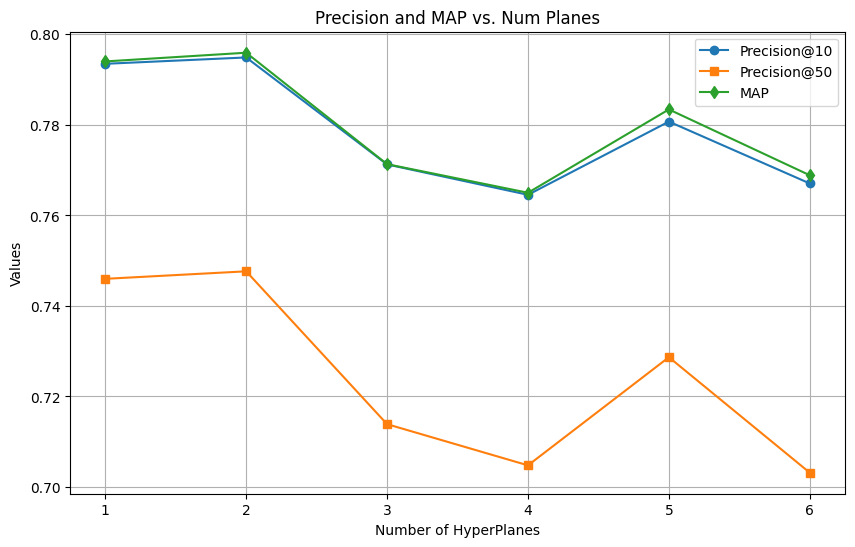

In [46]:
num_planes_list = list(range(1, 7))
prec_10_list = []
prec_50_list = []
map_list = []

for num_planes in tqdm(num_planes_list, desc='Processing Num Clusters:', total=len(num_planes_list)):
    prec_10, prec_50, map_value = run(train_features, train_labels, test_features, test_labels, num_planes)

    prec_10_list.append(prec_10)
    prec_50_list.append(prec_50)
    map_list.append(map_value)


import matplotlib.pyplot as plt

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(num_planes_list, prec_10_list, marker='o', label='Precision@10')
plt.plot(num_planes_list, prec_50_list, marker='s', label='Precision@50')
plt.plot(num_planes_list, map_list, marker='d', label='MAP')

# Adding titles and labels
plt.title('Precision and MAP vs. Num Planes')
plt.xlabel('Number of HyperPlanes')
plt.ylabel('Values')
plt.legend()
plt.grid(True)

plt.savefig('variation_with_num_hyperplanes.png', dpi=300)
# Show the plot
plt.show()